In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

if not torch.backends.mps.is_available():
    device = torch.device('cpu')
    if not torch.backends.mps.is_built():
        print("MPS not available because the current PyTorch install was not "
              "built with MPS enabled.")
    else:
        print("MPS not available because the current MacOS version is not 12.3+ "
              "and/or you do not have an MPS-enabled device on this machine.")

else:
    device = torch.device("mps")

model_path = "r34_best.pth"

# Basic block for ResNet
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion * planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion * planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion * planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out

# ResNet model
class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = 64  # Change the initial in_planes to 64 for ResNet-34

        self.conv1 = nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1, bias=False)  # 3 input channels for RGB images
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.linear = nn.Linear(35840 * block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = F.avg_pool2d(x, 4)
        x = x.view(x.size(0), -1)
        x = self.linear(x)
        return x

def ResNet34():
    return ResNet(BasicBlock, [3, 4, 6, 3])


In [2]:
net = ResNet34()

# Calculate the number of trainable parameters
total_params = sum(p.numel() for p in net.parameters() if p.requires_grad)
total_params

21634250

In [3]:
from util import load_data_from_split
split_songs = False
train_loader, val_loader, test_loader = load_data_from_split(resize_images=False, batch_size=10, split_songs=split_songs)

/Users/steven/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2.0 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [4]:
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from util import train_loop

net = ResNet34()
num_epochs = 20
criterion = nn.CrossEntropyLoss() # loss function

optimizer = optim.SGD(net.parameters(), lr=5e-3, momentum=0, weight_decay=1e-5)

scheduler = lr_scheduler.CyclicLR(optimizer, base_lr=1e-5, max_lr=1e-3, step_size_up=(num_epochs/2)*len(train_loader), step_size_down=(num_epochs/2)*len(train_loader), mode='triangular')

training_losses, validation_losses = train_loop(
    net=net,
    device=device,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion,
    model_path=model_path,
    split_songs=split_songs,
    num_epochs=num_epochs,
    optimizer=optimizer,
    scheduler=scheduler
)

Epoch 1 | LR: 1.00e-05 -> 1.09e-04 | Train Loss: 2.520 | Val Loss: 3.458 | Val Acc: 22.00%
Epoch 2 | LR: 1.09e-04 -> 2.08e-04 | Train Loss: 2.652 | Val Loss: 3.225 | Val Acc: 37.00%
Epoch 3 | LR: 2.08e-04 -> 3.07e-04 | Train Loss: 2.648 | Val Loss: 2.605 | Val Acc: 43.00%
Epoch 4 | LR: 3.07e-04 -> 4.06e-04 | Train Loss: 2.089 | Val Loss: 2.397 | Val Acc: 36.00%
Epoch 5 | LR: 4.06e-04 -> 5.05e-04 | Train Loss: 1.446 | Val Loss: 1.754 | Val Acc: 52.00%
Epoch 6 | LR: 5.05e-04 -> 6.04e-04 | Train Loss: 1.415 | Val Loss: 1.564 | Val Acc: 51.00%
Epoch 7 | LR: 6.04e-04 -> 7.03e-04 | Train Loss: 1.321 | Val Loss: 1.279 | Val Acc: 62.00%
Epoch 8 | LR: 7.03e-04 -> 8.02e-04 | Train Loss: 0.987 | Val Loss: 1.309 | Val Acc: 62.00%
Epoch 9 | LR: 8.02e-04 -> 9.01e-04 | Train Loss: 0.859 | Val Loss: 1.836 | Val Acc: 58.00%
Epoch 10 | LR: 9.01e-04 -> 1.00e-03 | Train Loss: 0.685 | Val Loss: 1.659 | Val Acc: 56.00%
Epoch 11 | LR: 1.00e-03 -> 9.01e-04 | Train Loss: 0.724 | Val Loss: 1.511 | Val Acc: 62.0

In [5]:
from util import test_model, test_model_aggregate

net = ResNet34()
net.to(device)

net.load_state_dict(torch.load(f"models/{model_path}"))

test_accuracy, test_loss = test_model(net, test_loader, device, criterion)

results_str = f"Test Accuracy | Idv: {test_accuracy:.2f}%"
if(split_songs):
    test_accuracy_agg = test_model_aggregate(net, test_loader, device)
    results_str += f", Agg: {test_accuracy_agg:.2f}%"

print(results_str)

Test Accuracy | Idv: 64.00%


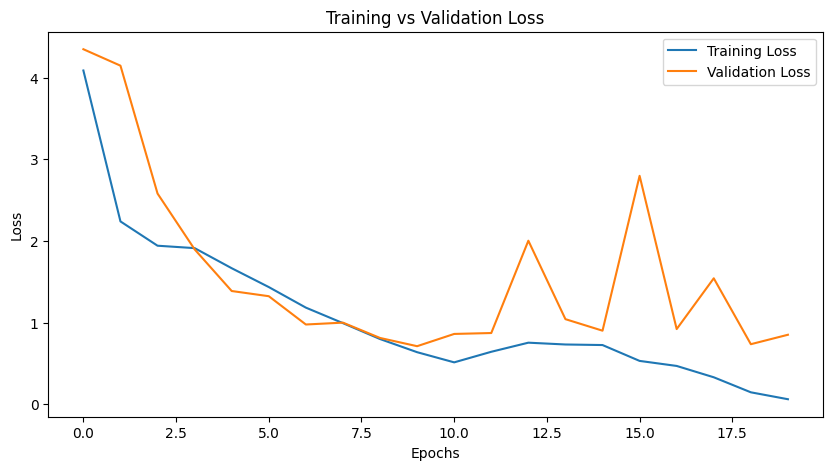

In [9]:
from util import plot_loss
print(training_losses, validation_losses)
plot_loss(training_losses, validation_losses)